In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import sys
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer, util
import torch

/Users/jhealynsamson/opt/anaconda3/envs/data_mining/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1) Load Dataset

In [20]:
df = pd.read_excel("./data_source/online_retail_II.xlsx", sheet_name=0)

df_C = df[df["Invoice"].astype(str).str.contains('C')]
print(f"Number of rows with C in Invoice: {len(df_C)}")
display(df[df["Invoice"].astype(str).str.contains('C')])

#Remove Invoice with c
df = df[~df['Invoice'].astype(str).str.contains('C')]
print(f"Number of rows after removing C: {len(df)}")
df.head()

Number of rows with C in Invoice: 10206


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom


Number of rows after removing C: 515255


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# 2) Data Exploration for Frequent itemset

### Check for duplicates

In [3]:
def checkduplicates(df, features_list):
    duplicates = df[df.duplicated(subset=features_list, keep=False)].sort_values(by=['Invoice','StockCode'])

    if not duplicates.empty:
        print(f"Found {len(duplicates)} duplicates based on the combination of 'Invoice', 'StockCode', 'InvoiceDate','Price','Country':")
        show_duplicates = pd.DataFrame(duplicates)
        display(show_duplicates)
    else:
        print("No duplicates found based on the combination of 'Invoice', 'StockCode', 'InvoiceDate','Price','Country'")

In [4]:
checkduplicates(df, ['Invoice','Description', 'StockCode', 'InvoiceDate','Price','Country','Customer ID','Quantity'])

Found 13236 duplicates based on the combination of 'Invoice', 'StockCode', 'InvoiceDate','Price','Country':


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
379,489517,21491,SET OF THREE VINTAGE GIFT WRAPS,1,2009-12-01 11:34:00,1.95,16329.0,United Kingdom
391,489517,21491,SET OF THREE VINTAGE GIFT WRAPS,1,2009-12-01 11:34:00,1.95,16329.0,United Kingdom
365,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
386,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
363,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
...,...,...,...,...,...,...,...,...
525170,538155,21907,I'M ON HOLIDAY METAL SIGN,1,2010-12-09 16:52:00,2.10,16907.0,United Kingdom
525292,538166,21915,RED HARMONICA IN BOX,5,2010-12-09 18:09:00,1.25,17965.0,United Kingdom
525293,538166,21915,RED HARMONICA IN BOX,5,2010-12-09 18:09:00,1.25,17965.0,United Kingdom
525330,538168,22739,RIBBON REEL CHRISTMAS SOCK BAUBLE,5,2010-12-09 19:23:00,1.65,14702.0,United Kingdom


### Remove duplicates

In [5]:
df_duplicate = df.drop_duplicates(subset=['Invoice','Description', 'StockCode', 'InvoiceDate','Price','Country','Customer ID','Quantity'])
checkduplicates(df_duplicate, ['Invoice','Description', 'StockCode', 'InvoiceDate','Price','Country','Customer ID','Quantity'])
df_duplicate = pd.DataFrame(df_duplicate)

No duplicates found based on the combination of 'Invoice', 'StockCode', 'InvoiceDate','Price','Country'


### Check Unique Values of Features

In [6]:
for column in df_duplicate.columns:
    print(f"{column}: {df_duplicate[column].unique()}")

Invoice: [489434 489435 489436 ... 538169 538170 538171]
StockCode: [85048 '79323P' '79323W' ... 22935 22933 21120]
Description: ['15CM CHRISTMAS GLASS BALL 20 LIGHTS' 'PINK CHERRY LIGHTS'
 ' WHITE CHERRY LIGHTS' ... '*Boombox Ipod Classic' 'faulty'
 'Dotcom sales']
Quantity: [   12    48    24    10    18     3    16     4     2     6     8     1
    28    30    60    32    56     9    25    36    20   576   288    27
   -96    64   160  -240  -192     5    72    50    54   -50     7   800
    11    58   192    96   144   100   180   216    15   240    22   108
    33    90    81    17    14    13    40    21   120   -44   230 -1043
  -117   200   168    19   280   128    80   300   450    61  -770  -720
   480    88    46   954  -954  -200   504    45   467 -1012  4320  5184
  4008   -25   600   505   500    23    74    47   -89   432   252    75
   184  -600  -169    31    38  -106   360   107   -23    49   -42    42
    66  -725   222    34    52   270   -20   -30   -60  3000   400

In [7]:
df_filtered = df_duplicate[df_duplicate['Quantity'] < 0]
display(df_filtered)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.0,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.0,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.0,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,NaN,United Kingdom
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
524458,538092,37467,NaN,-177,2010-12-09 14:49:00,0.0,NaN,United Kingdom
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.0,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.0,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.0,NaN,United Kingdom


In [8]:
has_alphabets = df_duplicate[df_duplicate['StockCode'].astype(str).str.contains(re.compile(r'[a-zA-Z]'))]
df_duplicate = df_duplicate[~df_duplicate['StockCode'].astype(str).str.contains(re.compile(r'[^0-9]'))]

print("StockCodes alphabets:", len(has_alphabets))
print("StockCodes with no alphabets:", len(df_duplicate))

StockCodes alphabets: 77148
StockCodes with no alphabets: 431266


### Remove all lowercase items from Description feature

All the non product items are lowercase

In [9]:
display(df_duplicate[pd.notna(df_duplicate['Description']) & df_duplicate['Description'].str.islower()])
mask = df_duplicate['Description'].str.isupper() & pd.notna(df_duplicate['Description'])
df_clean = df_duplicate[mask]

print(df_clean['Description'].unique())

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.0,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.0,NaN,United Kingdom
3162,489660,35956,lost,-1043,2009-12-01 17:43:00,0.0,NaN,United Kingdom
4538,489820,21133,invcd as 84879?,-720,2009-12-02 13:23:00,0.0,NaN,United Kingdom
9308,490130,21493,lost?,-600,2009-12-03 18:28:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
492226,535411,22734,amendment,20,2010-11-26 11:27:00,0.0,NaN,United Kingdom
509329,536942,22139,amazon,15,2010-12-03 12:08:00,0.0,NaN,United Kingdom
509330,536941,22734,amazon,20,2010-12-03 12:08:00,0.0,NaN,United Kingdom
518589,537639,22734,amazon,30,2010-12-07 15:29:00,0.0,NaN,United Kingdom


['15CM CHRISTMAS GLASS BALL 20 LIGHTS' 'RECORD FRAME 7" SINGLE SIZE '
 'STRAWBERRY CERAMIC TRINKET BOX' ... 'BAKING MOULD ROSE MILK CHOCOLATE'
 'BAKING MOULD CHOCOLATE CUP CAKES' 'BAKING MOULD EASTER EGG MILK CHOC']


### Check for missing data points

In [10]:
if df_clean.isnull().values.any():
    print("Warning: Missing data detected in the combined DataFrame!")
    missing_data = df_clean.isnull().sum()
    for column_name, num_missing in missing_data.items():
        if num_missing > 0:
            print(f"Column '{column_name}' has {num_missing} missing data points.")

Column 'Customer ID' has 84045 missing data points.


In [11]:
def check_column_similarity(df,list_columns, feature):
    counts = df.groupby(list_columns).size().reset_index(name='NumOccurences')

    duplicates = counts[counts.duplicated([feature], keep=False)]
    if not duplicates.empty:
        print(f"There are duplicate {list_columns[0]} values for different {list_columns[1]} values")
        print(duplicates)
        new_df = pd.DataFrame(duplicates)
        return new_df
    else: 
        print(f"All {list_columns[0]} values appear with only one {list_columns[1]} value")

In [12]:
check_column_similarity(df_clean, ["Invoice", "Customer ID"], "Invoice")

All Invoice values appear with only one Customer ID value


In [13]:
df_clean_check = df_clean[["Invoice", "Customer ID"]]
df_clean_check_dp = df_clean_check.drop_duplicates(subset=["Invoice","Customer ID"])
display(df_clean_check_dp)

,Invoice,Customer ID
0,489434,13085.0
8,489435,13085.0
13,489436,13078.0
31,489437,15362.0
54,489438,18102.0
...,...,...
525303,538167,14713.0
525328,538168,14702.0
525358,538169,13230.0
525371,538170,13969.0


- Invoice and Customer ID cannot be used interchangeably because Customer ID to Invoice is a one to many relationship. The missing customer ID need to be dropped, however, it needs to be checked first if the missing customer ids can be populated. E.g, in two transactions for the same customer one row is missing the customer id and the other isn't. To map both, the Invoice feature will be used

In [14]:
new_df = check_column_similarity(df_clean, ["StockCode", "Description"], "StockCode")

There are duplicate StockCode values for different Description values
      StockCode                          Description  NumOccurences
16        16011                      ANIMAL STICKERS             12
17        16011                      ANIMAL STICKERS             56
18        16012           FOOD/DRINK SPONGE STICKERS             29
19        16012           FOOD/DRINK SPUNGE STICKERS             20
63        20615         BLUE POLKADOT PASSPORT COVER             21
...         ...                                  ...            ...
3026      85216                          DOTCOM SETS              1
3034      85227       SET OF 6 3D KIT CARDS FOR KIDS            191
3035      85227          SET/6 3D KIT CARDS FOR KIDS             51
3140      90208  PAIR OF ENAMEL FLOWER CLUSTER SLIDE             30
3141      90208    PAIR OF PINK FLOWER CLUSTER SLIDE              3

[766 rows x 3 columns]


### Replace mismatching Descriptions

In [15]:
reference_df = new_df.sort_values(by=['NumOccurences'], ascending=False).drop_duplicates(subset=['StockCode'], keep='first')
display(reference_df.sort_values(by=['StockCode','NumOccurences'], ascending=False))

,StockCode,Description,NumOccurences
3140,90208,PAIR OF ENAMEL FLOWER CLUSTER SLIDE,30
3034,85227,SET OF 6 3D KIT CARDS FOR KIDS,191
3025,85216,ASSORTED CAKES FRIDGE MAGNETS,181
2971,85103,SILVER T-LIGHT SETTING,42
2910,84969,ASSORTED COLOUR SET 6 TEASPOONS,86
...,...,...,...
79,20658,RED SPOTTY LUGGAGE TAG,196
73,20652,BLUE SPOTTY LUGGAGE TAG,81
64,20615,BLUE SPOTTY PASSPORT COVER,89
18,16012,FOOD/DRINK SPONGE STICKERS,29


In [16]:
merged_df = pd.merge(df_clean, reference_df, on='StockCode', how='left')
merged_df['Description_x'] = merged_df['Description_y'].fillna(merged_df['Description_x'])
merged_df.drop(['Description_y','NumOccurences'], axis=1, inplace=True)
# display(merged_df)

check_column_similarity(merged_df, ["StockCode", "Description_x"], "StockCode")

All StockCode values appear with only one Description_x value


In [17]:
df_final = merged_df

### Feature Engineering

Added 2 new features:
1) Recurring Customer
2) Sales

In [18]:
df_final['Recurring Customer'] = df_final.duplicated(subset=['Customer ID']).astype(int).replace({True: 0, False: 1})
recurring_customers = len(df_final[(df_final['Recurring Customer']==1)])
not_recurring_customers = len(df_final[(df_final['Recurring Customer']==0)])

print(f"Number of Recurring Customers:{recurring_customers} and Number of not recurring customers: {not_recurring_customers}")

Number of Recurring Customers:424043 and Number of not recurring customers: 4249


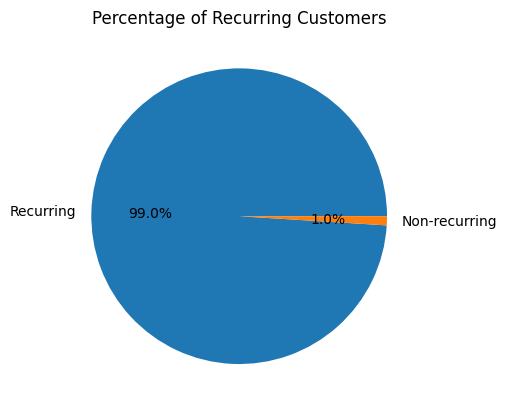

In [27]:
# create a pie chart
counts = df_final['Recurring Customer'].value_counts()
plt.pie(counts, labels=['Recurring', 'Non-recurring'], autopct='%1.1f%%')
plt.title('Percentage of Recurring Customers')
plt.show()

In [33]:
df_final['Sale'] = df_final['Quantity'] * df_final['Price']
print("Top 10 selling items")
df_final.sort_values(by=['Sale'], ascending=False).head(10)

Top 10 selling items


,Invoice,StockCode,Description_x,Quantity,InvoiceDate,Price,Customer ID,Country,Recurring Customer,Sale
349034,530715,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,9360,2010-11-04 11:36:00,1.69,15838.0,United Kingdom,1,15818.40
374130,533027,22086,PAPER CHAIN KIT 50'S CHRISTMAS,835,2010-11-15 16:02:00,6.95,NaN,United Kingdom,1,5803.25
304593,525968,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,3120,2010-10-08 10:10:00,1.66,15838.0,United Kingdom,1,5179.20
286602,524181,21622,VINTAGE UNION JACK CUSHION COVER,648,2010-09-27 16:59:00,6.89,17450.0,United Kingdom,1,4464.72
366099,532358,84879,ASSORTED COLOUR BIRD ORNAMENT,2880,2010-11-11 17:05:00,1.45,12931.0,United Kingdom,1,4176.00
339305,529613,22423,REGENCY CAKESTAND 3 TIER,360,2010-10-29 10:46:00,10.95,17949.0,United Kingdom,1,3942.00
313886,526934,22790,"MIRROR, ARCHED GEORGIAN",200,2010-10-14 09:46:00,19.42,18102.0,United Kingdom,1,3884.00
286604,524181,21624,VINTAGE UNION JACK DOORSTOP,648,2010-09-27 16:59:00,5.96,17450.0,United Kingdom,1,3862.08
423137,537659,21623,VINTAGE UNION JACK MEMOBOARD,600,2010-12-07 16:43:00,6.38,18102.0,United Kingdom,1,3828.00
426070,537899,22328,ROUND SNACK BOXES SET OF 4 FRUITS,1488,2010-12-09 10:44:00,2.55,12755.0,Japan,1,3794.40


In [47]:
df_country = df_final[["Country","Quantity","Sale"]]
len_df_country  = df_country.groupby('Country').agg({'Quantity': 'sum', 'Sale': 'sum'})
total_sale = len_df_country['Sale'].sum()
len_df_country[' % of_sale'] = len_df_country['Sale'] / total_sale * 100

print(f"The number of countries:{len(len_df_country)}")
display(len_df_country.sort_values(by=['Sale'], ascending=False))

The number of countries:40


,Quantity,Sale,% of_sale
Country,,,
United Kingdom,4046929,7094595.77,85.681969
EIRE,173684,314714.92,3.800836
Netherlands,164789,231549.95,2.796446
Germany,98640,164239.19,1.983529
France,135025,113932.67,1.375973
Sweden,51302,46570.97,0.562441
Denmark,204791,44129.60,0.532957
Switzerland,20140,36797.66,0.444408
Spain,19224,33689.88,0.406875


### Scatterplot of dataset

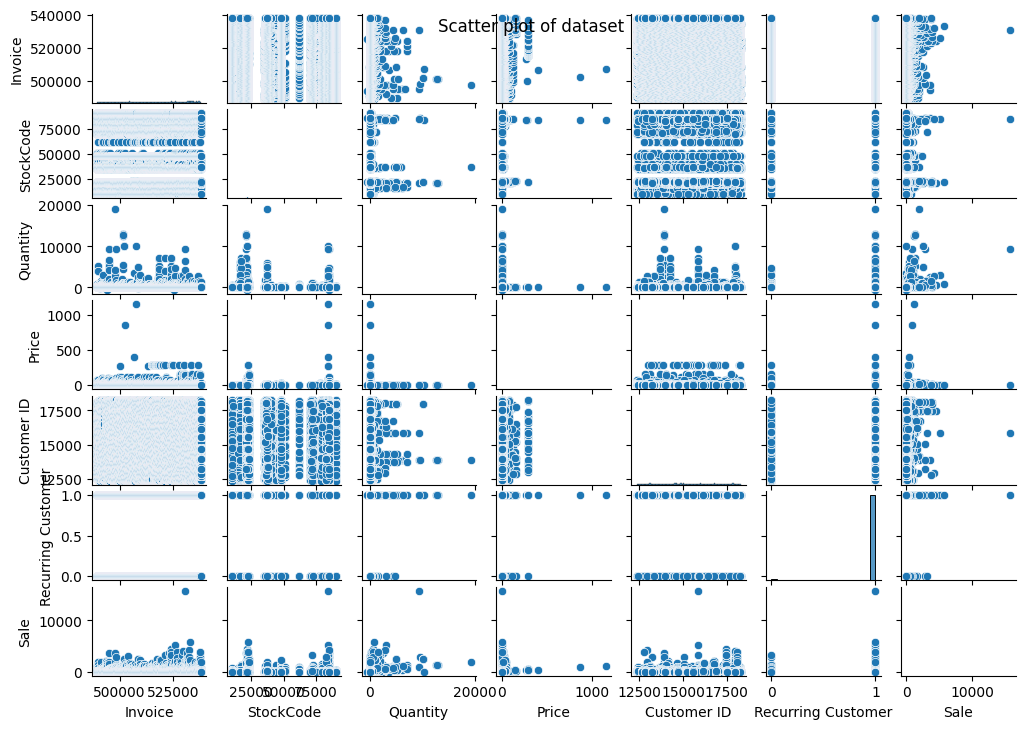

In [24]:
df_plot = df_final
g = sns.pairplot(
    df_plot)
g.fig.suptitle('Scatter plot of dataset')
g.fig.set_figheight(7)
g.fig.set_figwidth(10)
# g.map_offdiag(correlation)
plt.show()

### Correlation of dataset

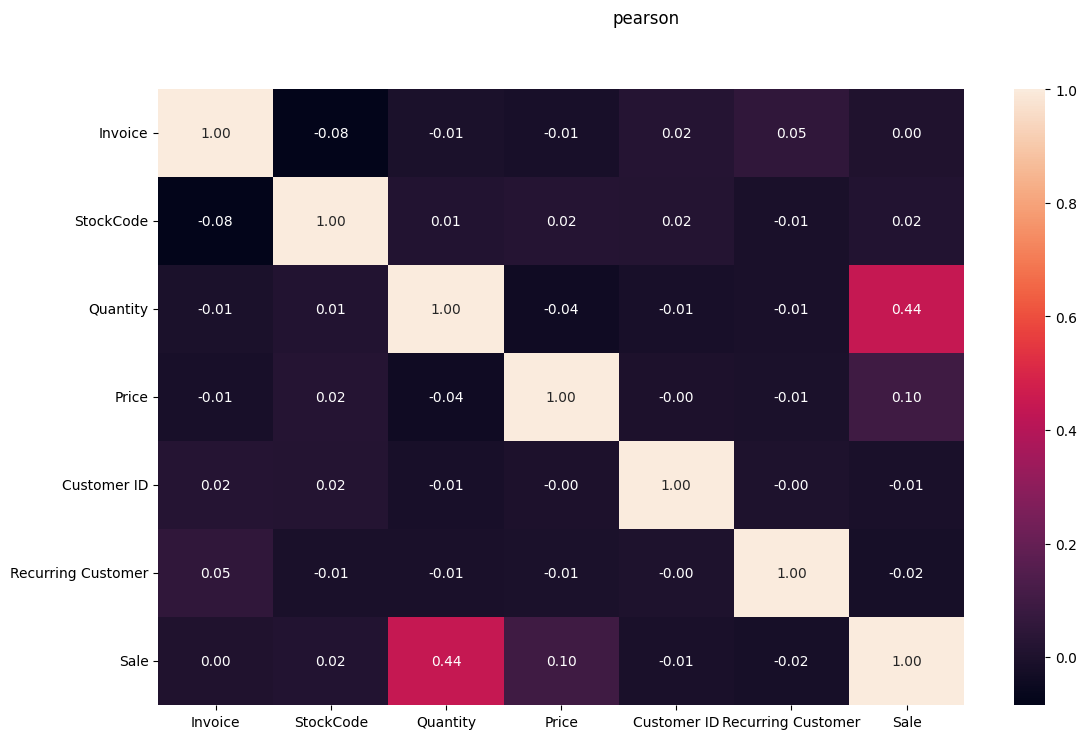

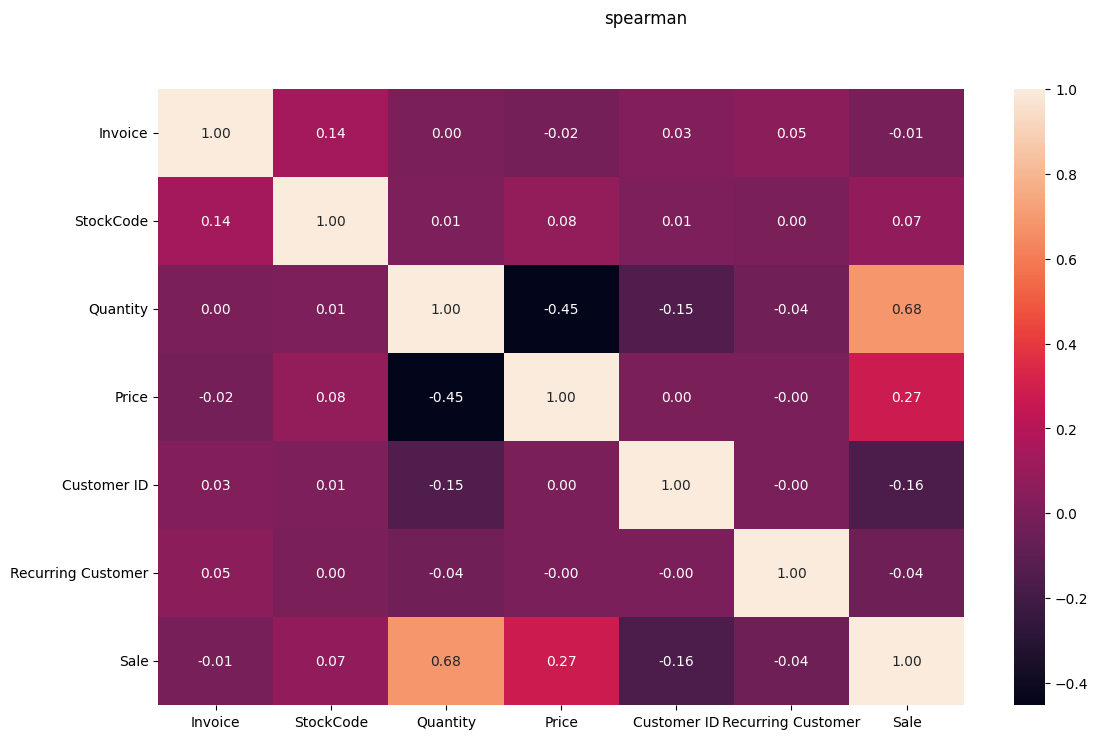

In [25]:
df_final["StockCode"]= df_final["StockCode"].astype(int)
df_final["Invoice"]= df_final["Invoice"].astype(int)


items = ['pearson', 'spearman']
for item in items:
    fig, axe = plt.subplots(figsize=(13,8))
    fig.suptitle(item)
    sns.heatmap(df_final.corr(item, numeric_only=True), annot=True, fmt='.2f')
    plt.show()

## Modelling

In [ ]:
#Preprocessing 1: Clean up Product Name. Remove Numbers and odd characters
df_final['Description_x'] = df_final['Description_x'].str.lower().replace('[^a-zA-Z ]', '')
df_final['Description_x'].str.strip()

#Preprocessing 2: Group by Order ID
def groupdataset(dataset,groupbysecondval):
    associated_df = (dataset.groupby(['Invoice', groupbysecondval])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('Invoice'))
    associated_df[associated_df != 0] = 1
    return associated_df

#Preprocessing 3: Convert all values that is not 0 to 1
def encode_units(x):
    return 1 if x >= 1 else 0

In [ ]:
#Apiori Algorithm
def apiori(dataset, minsupport):
    basket_sets = dataset.applymap(encode_units)
    frequent_itemsets = apriori(basket_sets, min_support=minsupport, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    print(basket_sets)
    return rules

In [ ]:
associated_df = groupdataset(df_final,'Description_x')
rules = apiori(associated_df, 0.01)
rules

In [ ]:
def extractclasses(dataset):
    productname1 =[]
    productname2 = []
    groupedproductname = []

    #Group sentences
    sentences = dataset['Description_x'].astype(str).fillna('')
    for i,j in enumerate(sentences):
        x = j.split()
        for y in x:
            productname1.append(y)

    [productname2.append(j) for i,j in enumerate(sentences)]
    groupedproductname = productname1 + productname2

    #Run CountVector
    cv=CountVectorizer()
    vect=cv.fit_transform(groupedproductname)
    km=KMeans(n_clusters=100)
    pred = km.fit_predict(vect)

    classnames = []
    for i,j in enumerate(pred):
        classnames.append(groupedproductname[j])

    classnames = set(classnames)
    print(*list(classnames), sep = ",")

In [ ]:
extractclasses(df_final)

In [ ]:
online_list = ['stationery set', 'tape dispenser', 'purse','incense','incense holder','keychains'
              ,'candle holder','envelope','passport cover','luggage tag','decoration/lights/signs'
              ,'bowl','parasol/umbrella','doormat','expresso cups','soft toy','bag/lunch bag/lunch box'
              ,'cases','gloves','pocket book','sketch book','journal','notebook','napkin'
              ,'headphone','stool','tray','glass dish','mirror','wine glass','cups','photo frame'
              ,'stickers','fan','scissor','letters','ornament','dormat','plate','trinket','clock'
              ,'bracelet','earring','necklace','brooch','apron','comb','mug','bottle','sets','slipper'
              ,'spoons','cutlery','box','ceramic','rubber/eraser','memo pad','to do list','sharpener','pencil/pen']

In [ ]:
def semanticSimilarityFunction(dataset, compareList):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    productname2 = []
    tempdictionary = []
    sentences = dataset['Description_x']
    [productname2.append(j) for i,j in enumerate(sentences)]

  #Compute embedding for both lists
    embeddings1 = model.encode(productname2, convert_to_tensor=True)
    embeddings2 = model.encode(compareList, convert_to_tensor=True)

  #Compute cosine-similarities
    cosine_scores = util.cos_sim(embeddings1, embeddings2)

    k = torch.topk(cosine_scores, 1, dim=1, largest=True, sorted=True)

#     for j in compareList:
#         tempdictionary[j] = []
    for i in range(len(productname2)):
#         print("Key Word:{} \tSuggested Class(label):{} \tScore:{}".format(productname2[i],compareList[k.indices[[i]]], k.values[[i]]))
        tempdictionary.append([compareList[k.indices[i]],productname2[i]])
    return tempdictionary

In [ ]:
df_final = df_final.dropna(subset=['Description_x'])
df_final = df_final[~df_final['Description_x'].str.contains('nan')]

In [ ]:
df_final['Description_x'] = df_final['Description_x'].astype(str)
reference_list = semanticSimilarityFunction(df_final,online_list)
reference_df = pd.DataFrame(reference_list, columns=['new_description', 'old_description'])


In [ ]:
display(reference_df)

In [ ]:
df_final = df_final.reset_index()
generalised_df = df_final
generalised_df["new_description"] = reference_df["new_description"]

In [ ]:
display(reference_df)
display(generalised_df)
# display(generalised_df[generalised_df['new_description'] == None])

In [ ]:
# Run the apiori model again
associated_df = groupdataset(generalised_df,'new_description')
rules = apiori(associated_df, 0.03)
rules